###**PART 1:**Installing pyspark, libraries, and Reading files

**Installing** **Pyspark**

In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285387 sha256=c28be7c67644941819af4613ddaa69b1f51cbfa6942da3d27f9f4da8a15ac840
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


Import SparkSession, Pandas, Seaborn, Matplot, and Numpy Libraries

In [ ]:
from pyspark.sql import SparkSession

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
%matplotlib inline


In [ ]:
spark = SparkSession.Builder().master("local").appName("100631870- Processing Big Data").getOrCreate()


In [ ]:
#Importing the Fact and Dimensions Tables
from google.colab import files
uploads = files.upload()

Saving DimCurrency.csv to DimCurrency.csv
Saving DimCustomer.csv to DimCustomer.csv
Saving DimDate.csv to DimDate.csv
Saving DimGeography.csv to DimGeography.csv
Saving DimProduct.csv to DimProduct.csv
Saving DimProductCategory.csv to DimProductCategory.csv
Saving DimProductSubcategory.csv to DimProductSubcategory.csv
Saving DimPromotion.csv to DimPromotion.csv
Saving DimSalesTerritory.csv to DimSalesTerritory.csv
Saving FactInternetSales.csv to FactInternetSales.csv


In [ ]:
#Reading the imported tables
FactSales = spark.read.csv("/content/FactInternetSales.csv", header=True)
DimCustomer = spark.read.csv("/content/DimCustomer.csv", header=True)
DimCurrency = spark.read.csv("/content/DimCurrency.csv", header=True)
DimGeography = spark.read.csv("/content/DimGeography.csv", header=True)
DimSalesTerritory = spark.read.csv("/content/DimSalesTerritory.csv", header=True)
DimProduct= spark.read.csv("/content/DimProduct.csv", header=True)
DimProdSubcategory = spark.read.csv("/content/DimProductSubcategory.csv", header=True)
DimProdCategory = spark.read.csv("/content/DimProductCategory.csv", header=True)
DimPromotion = spark.read.csv("/content/DimPromotion.csv", header=True)

### **EDA, Segmentation, and Classification Analysis**

Merging the FactInternetSales,Customer and Product Dimensions Tables

In [ ]:
#Customer Dimension Table
#Selecting columns and viewing table
Dimcustomer = DimCustomer.select(['CustomerKey','BirthDate','Gender','EnglishEducation','TotalChildren','YearlyIncome','HouseOwnerFlag','NumberCarsOwned','NumberChildrenAtHome','MaritalStatus'])
Dimcustomer.show(3)
Dimcustomer.printSchema()




+-----------+----------+------+----------------+-------------+------------+--------------+---------------+--------------------+-------------+
|CustomerKey| BirthDate|Gender|EnglishEducation|TotalChildren|YearlyIncome|HouseOwnerFlag|NumberCarsOwned|NumberChildrenAtHome|MaritalStatus|
+-----------+----------+------+----------------+-------------+------------+--------------+---------------+--------------------+-------------+
|      11000|1971-10-06|     M|       Bachelors|            2|    90000.00|             1|              0|                   0|            M|
|      11001|1976-05-10|     M|       Bachelors|            3|    60000.00|             0|              1|                   3|            S|
|      11002|1971-02-09|     M|       Bachelors|            3|    60000.00|             1|              1|                   3|            M|
+-----------+----------+------+----------------+-------------+------------+--------------+---------------+--------------------+-------------+
only s

In [ ]:
# To calculate the age of each customer
from pyspark.sql import functions as f
#Extract year from birthdate
Dimcustomer1 = Dimcustomer.withColumn('year', f.split(DimCustomer['BirthDate'], '-').getItem(0)) \
#Calculate the age
Dimcustomer1.show(3)
Dimcustomer2 = Dimcustomer1.withColumn('Age', 2023 -Dimcustomer1['Year'])
#Change the new column to Integer
Dimcustomer3 = Dimcustomer2.withColumn(colName ='Age', col=f.col('Age').cast('Integer'))
Dimcustomer3.show(3)
Dimcustomer3.printSchema()
#Dimcustom = Dimcustomer3.toPandas()


+-----------+----------+------+----------------+-------------+------------+--------------+---------------+--------------------+-------------+----+
|CustomerKey| BirthDate|Gender|EnglishEducation|TotalChildren|YearlyIncome|HouseOwnerFlag|NumberCarsOwned|NumberChildrenAtHome|MaritalStatus|year|
+-----------+----------+------+----------------+-------------+------------+--------------+---------------+--------------------+-------------+----+
|      11000|1971-10-06|     M|       Bachelors|            2|    90000.00|             1|              0|                   0|            M|1971|
|      11001|1976-05-10|     M|       Bachelors|            3|    60000.00|             0|              1|                   3|            S|1976|
|      11002|1971-02-09|     M|       Bachelors|            3|    60000.00|             1|              1|                   3|            M|1971|
+-----------+----------+------+----------------+-------------+------------+--------------+---------------+------------

In [ ]:
#Joining the tables
ClassTab = FactSales.join(DimProduct, how="inner",on=["ProductKey"])
ClassTab2 = ClassTab.join(Dimcustomer3,how="inner",on=["CustomerKey"])

ClassTab2.show(2)


+-----------+----------+------------+----------+-----------+------------+-----------+-----------------+----------------+--------------------+--------------+-------------+---------+--------------+--------------------+--------------+-------------------+----------------+-----------+--------+-------+---------------------+----------------+--------------------+--------------------+--------------------+-------------------+---------------------+---------------------+-------------------+--------------------+--------------------+--------------------+------------+-----------------+------+----------------+------------+---------+----+---------+------+-----------------+-----------+-----------+-----+-----+------------+--------------------+----------------+----------------+------+----------+------+----------------+-------------+------------+--------------+---------------+--------------------+-------------+----+---+
|CustomerKey|ProductKey|OrderDateKey|DueDateKey|ShipDateKey|PromotionKey|CurrencyKey|Sa

In [ ]:
#Grouping the tables and aggregating total spent and count by customer ID
from pyspark.sql.functions import desc
from pyspark.sql.functions import *
ClassTab_selection = ClassTab2.select(['CustomerKey','Age','Gender','EnglishEducation','YearlyIncome','TotalChildren','HouseOwnerFlag','NumberCarsOwned','NumberChildrenAtHome','MaritalStatus','OrderQuantity','TaxAmt','UnitPrice','TotalProductCost']) \
.groupBy("CustomerKey","Age","Gender","EnglishEducation","YearlyIncome","HouseOwnerFlag","NumberCarsOwned","MaritalStatus","TotalChildren",'NumberChildrenAtHome').agg(count(col("OrderQuantity"))) \
.orderBy(desc(count(col("OrderQuantity")))) \

TSpent = ClassTab2.select(['CustomerKey','Age','Gender','EnglishEducation','YearlyIncome','TotalChildren','HouseOwnerFlag','NumberCarsOwned','NumberChildrenAtHome','MaritalStatus','OrderQuantity','TaxAmt','UnitPrice','TotalProductCost']) \
.groupBy("CustomerKey").agg(sum(col("TotalProductCost"))) \
.orderBy(desc(sum(col("TotalProductCost")))) \

FinalCustab = ClassTab_selection.join(TSpent, how="inner", on=["CustomerKey"])

FinalCustab.show(5)
FinalCustab.printSchema()

+-----------+---+------+----------------+------------+--------------+---------------+-------------+-------------+--------------------+--------------------+---------------------+
|CustomerKey|Age|Gender|EnglishEducation|YearlyIncome|HouseOwnerFlag|NumberCarsOwned|MaritalStatus|TotalChildren|NumberChildrenAtHome|count(OrderQuantity)|sum(TotalProductCost)|
+-----------+---+------+----------------+------------+--------------+---------------+-------------+-------------+--------------------+--------------------+---------------------+
|      13538| 47|     F| Partial College|    20000.00|             1|              1|            S|            2|                   0|                   3|   3436.3617999999997|
|      17247| 46|     M|       Bachelors|    90000.00|             1|              3|            M|            0|                   0|                   5|            2647.7877|
|      11072| 63|     F|     High School|    80000.00|             0|              2|            S|           

In [ ]:
#Converting selected table to Pandas for visualization
TAB23 = FinalCustab.toPandas()
TAB23.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18484 entries, 0 to 18483
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   CustomerKey            18484 non-null  object 
 1   Age                    18484 non-null  int32  
 2   Gender                 18484 non-null  object 
 3   EnglishEducation       18484 non-null  object 
 4   YearlyIncome           18484 non-null  object 
 5   HouseOwnerFlag         18484 non-null  object 
 6   NumberCarsOwned        18484 non-null  object 
 7   MaritalStatus          18484 non-null  object 
 8   TotalChildren          18484 non-null  object 
 9   NumberChildrenAtHome   18484 non-null  object 
 10  count(OrderQuantity)   18484 non-null  int64  
 11  sum(TotalProductCost)  18484 non-null  float64
dtypes: float64(1), int32(1), int64(1), object(9)
memory usage: 1.6+ MB


In [ ]:
#Converting datatypes and renaming some selected columns
TAB23['YearlyIncome'] = TAB23['YearlyIncome'].astype(float)
TAB23['TotalChildren'] = TAB23['TotalChildren'].astype(float)
TAB23['HouseOwnerFlag'] = TAB23['HouseOwnerFlag'].astype(float)
TAB23['NumberChildrenAtHome'] = TAB23['NumberChildrenAtHome'].astype(float)
TAB23['NumberCarsOwned'] = TAB23['NumberCarsOwned'].astype(float)

TAB23.rename(columns = {'sum(TotalProductCost)':'TotalSpent','count(OrderQuantity)':'TotalOrders'}, inplace = True)

TAB23.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18484 entries, 0 to 18483
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CustomerKey           18484 non-null  object 
 1   Age                   18484 non-null  int32  
 2   Gender                18484 non-null  object 
 3   EnglishEducation      18484 non-null  object 
 4   YearlyIncome          18484 non-null  float64
 5   HouseOwnerFlag        18484 non-null  float64
 6   NumberCarsOwned       18484 non-null  float64
 7   MaritalStatus         18484 non-null  object 
 8   TotalChildren         18484 non-null  float64
 9   NumberChildrenAtHome  18484 non-null  float64
 10  TotalOrders           18484 non-null  int64  
 11  TotalSpent            18484 non-null  float64
dtypes: float64(6), int32(1), int64(1), object(4)
memory usage: 1.6+ MB


In [ ]:
#Histogram to check distribution of Age of the Customers
sns.histplot(data=TAB23, x="Age", bins = list(range(10, 150, 10)))
plt.title("Distribution of Customer's Age")
plt.show()

NameError: ignored

In [ ]:
TAB23["EnglishEducation"].value_counts()

Bachelors              5356
Partial College        5064
High School            3294
Graduate Degree        3189
Partial High School    1581
Name: EnglishEducation, dtype: int64

In [ ]:
#Grouping Customers in Age Groups
def group_age(age):
    if age <20:
        return "11-20"
    elif age > 20 and age <31:
        return "21-30"
    elif age > 30 and age <41:
        return "31-40"
    elif age > 40 and age <51:
        return "41-50"
    elif age > 50 and age <61:
        return "51-60"
    elif age > 60 and age <71:
        return "61-70"
    elif age > 70 and age <81:
        return "71-80"
    elif age > 80:
        return ">80"


In [ ]:
TAB23["Age Group"] =TAB23["Age"].apply(group_age)

# To order plotly index
order = ["21-30", "31-40", "41-50", "51-60", "61-70", "71-80", ">80"]


In [ ]:
#Average Total Spent by Age Group
mask = TAB23.groupby("Age Group")["TotalSpent"].mean()
mask = mask.reset_index()
fig = px.bar(data_frame=mask, x="Age Group", y="TotalSpent", height=500, width=600,title = "Relationship between Customer Age Group and Average TotalSpent")


fig.update_xaxes(categoryorder='array', categoryarray= order)
#fig.update_layout(annotations=annotation)
fig.show()

In [ ]:
#Marital Status
mask = TAB23.groupby("MaritalStatus")["YearlyIncome"].mean()
mask = mask.reset_index()
fig = px.bar(data_frame=mask, x="MaritalStatus", y="YearlyIncome", height=500,width=400,
             title="Relationship between Customer's Marital Status\
              and Income")
fig.show()

In [ ]:
#Frequency of Customers Education
TAB23["EnglishEducation"].value_counts(normalize=True).plot.bar(figsize=(8, 6))
plt.xticks(rotation=10)
plt.title("Frequency of Customer's Education");

NameError: ignored

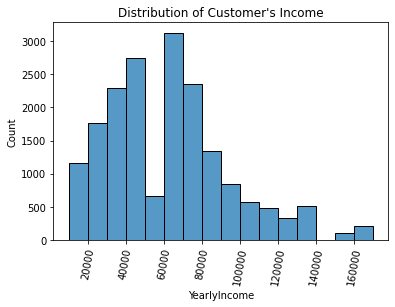

In [ ]:
#Distribution of Income
sns.histplot(data=TAB23, x="YearlyIncome", binwidth=1e4)
plt.xticks(rotation= 80)
plt.title("Distribution of Customer's Income");

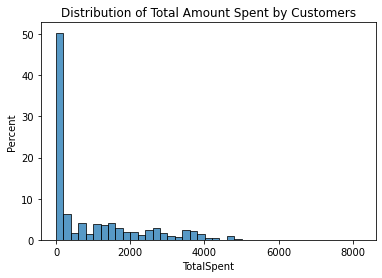

In [ ]:
#Distribution of Total Spent
sns.histplot(data=TAB23, x="TotalSpent", binwidth=200, stat="percent")
plt.title("Distribution of Total Amount Spent by Customers");


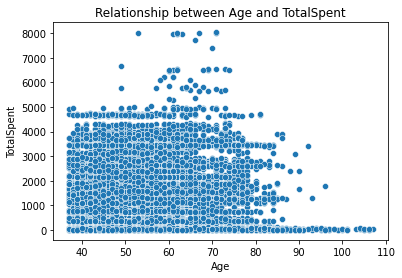

In [ ]:
#Bivarate Analysis
#Age vs Amount Spent
sns.scatterplot(data=TAB23, x="Age", y="TotalSpent")
plt.title("Relationship between Age and TotalSpent");

In [ ]:
#Education Vs Total Amount Spent
mask = TAB23.groupby("EnglishEducation")["TotalSpent"].mean()
mask = mask.reset_index()
fig = px.bar(data_frame=mask, x="EnglishEducation", y="TotalSpent", height=500,width=700,
            title = "Relationship bewtween Education and Average TotalSpent")
#fig.update_layout(annotations=annotation)
fig.show()

In [ ]:
#Education Vs Average Income
mask = TAB23.groupby("EnglishEducation")["YearlyIncome"].mean()
mask = mask.reset_index()
fig = px.bar(data_frame=mask, x="EnglishEducation", y="YearlyIncome", height=500,width=800,
            title = "Relationship bewteen Education and Average YearlyIncome")


fig.show()

Text(0.5, 1.0, 'Correlation plot of YearlyIncome against TotalSpent')

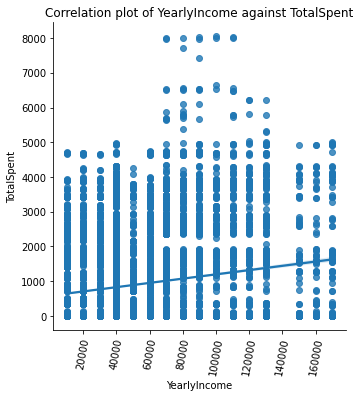

In [ ]:
#Correlation between YearlyIncome and TotalSpent
sns.lmplot(x='YearlyIncome',y='TotalSpent',data=TAB23)
plt.xticks(rotation= 80)
plt.title("Correlation plot of YearlyIncome against TotalSpent")

Text(0.5, 1.0, 'Correlation plot of TotalCHildren against TotalSpent')

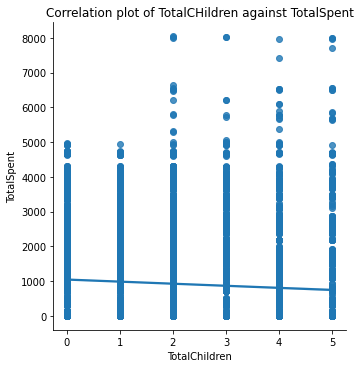

In [ ]:
sns.lmplot(x='TotalChildren',y='TotalSpent',data=TAB23)
plt.title("Correlation plot of TotalCHildren against TotalSpent")

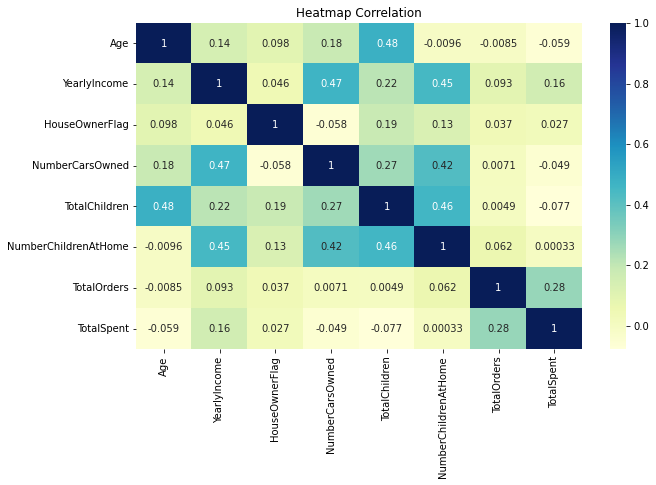

In [ ]:
#Multivariate correlation analysis
plt.figure(figsize=(10,6))
sns.heatmap(TAB23.corr(), cmap="YlGnBu", annot=True)
plt.title("Heatmap Correlation")
plt.show()

In [ ]:
#Age has the highest correlation with total Number of Children.
#YearlyIncome has positive correlation with Number of Cars owned by Customers
#Other relation degrees are very low with each other.

**Conclusion From EDA**

The customers' level of education is a key indicator that determines the yealy income.The highly educated customers who earn the most also spend more than the other groups.

It is noticed that customers age has no influence on how much they spend or make in income.

Also, there trends in terms of total number of children and totalamount spent. On average there is a decline is total spent with increase in number of children.

**Customer Segmentation Analysis**

In [ ]:
#CUstomer Segmentation Using Kmeans
#Building the KMeans Model
#We will build the Kmeans Model using 3 Features to Segment the Customers Demographic and Behaviour "Age',"Income" and "Total Amount Spent"
TAB23["YearlyIncome"].fillna(TAB23["YearlyIncome"].median(), inplace=True)
data = TAB23[["Age","YearlyIncome", "TotalSpent"]]
TAB23_log = np.log(data)
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
std_scaler = StandardScaler()
TAB23_scaled = std_scaler.fit_transform(TAB23_log)

errors = []
for k in range(1, 11):
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(TAB23_scaled)
    errors.append(model.inertia_)



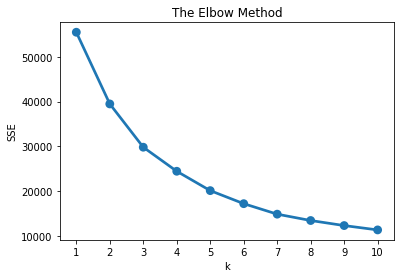

In [ ]:
plt.title('The Elbow Method')
plt.xlabel('k'); plt.ylabel('SSE')
sns.pointplot(x=list(range(1, 11)), y=errors)
plt.show()

In [ ]:
#Building the Kmeans using 3 clusters
model = KMeans(n_clusters=3, random_state=44)
model.fit(TAB23_scaled)

KMeans(n_clusters=3, random_state=44)

In [ ]:
#The clusters are then assigned
data = data.assign(ClusterLabel= model.labels_)
result = data.groupby("ClusterLabel").agg({"Age":"mean", "YearlyIncome":"median", "TotalSpent":"median"}).round()
result

,Age,YearlyIncome,TotalSpent
ClusterLabel,,,
0,61.0,70000.0,22.0
1,54.0,60000.0,1620.0
2,46.0,30000.0,30.0


In [ ]:
#Interpreting the cluster Label.
#Cluster 0: Middle Age Average Joes (Low Income Low Spend)
#Cluster 1: Old Age low spenders (High Income but very low spending
#Cluster 2: Old Age High Rollers (High Income and High Spending)


In [ ]:
#Plot to view result
fig = px.scatter(
    data_frame=data,
    x = "YearlyIncome",
    y= "TotalSpent",
    title = "Relationship between YearlyIncome VS TotalSpent",
    color = "ClusterLabel",
    height=400,
    width=600

)
fig.show()

Interpretation of result

•	Cluster 0 represents middle aged customers that earn low and spend low.

•	Cluster 1 depicts old customer that earn lot but spend very low.

•	Cluster 2 are older customers that earn high and also spend a lot.


In [ ]:
TAB23.isnull().sum()

CustomerKey             0
Age                     0
Gender                  0
EnglishEducation        0
YearlyIncome            0
HouseOwnerFlag          0
NumberCarsOwned         0
MaritalStatus           0
TotalChildren           0
NumberChildrenAtHome    0
TotalOrders             0
TotalSpent              0
Age Group               0
dtype: int64

**Classification Analysis**

In [ ]:
#Classification Analysis using Decision Trees and Random Forest Classification

# Splitting the dataset features into X and y
X = TAB23[['Age', 'YearlyIncome','Gender','EnglishEducation','MaritalStatus']]
y = TAB23['HouseOwnerFlag']

#Passing dummies to the categoriacal variables
columns = ['Gender','EnglishEducation','MaritalStatus']
X = pd.get_dummies(X[columns])

X.head(5)

,Gender_F,Gender_M,EnglishEducation_Bachelors,EnglishEducation_Graduate Degree,EnglishEducation_High School,EnglishEducation_Partial College,EnglishEducation_Partial High School,MaritalStatus_M,MaritalStatus_S
0,1,0,0,0,0,1,0,0,1
1,0,1,1,0,0,0,0,1,0
2,1,0,0,0,1,0,0,0,1
3,0,1,0,0,1,0,0,1,0
4,1,0,1,0,0,0,0,0,1


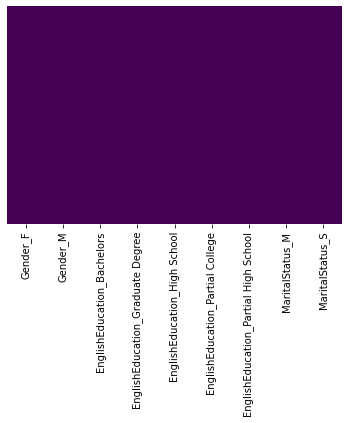

In [ ]:
#Checking for null values
sns.heatmap(X.isnull(),yticklabels=False,cbar=False,cmap='viridis')

1.0    12502
0.0     5982
Name: HouseOwnerFlag, dtype: int64


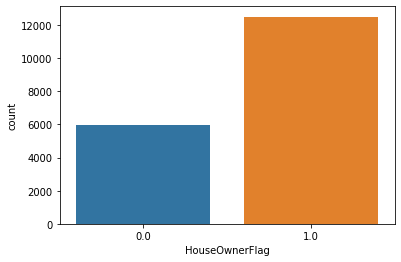

In [ ]:
#to check for oversampling
ax = sns.countplot(x=TAB23['HouseOwnerFlag'],data=TAB23)
print(TAB23['HouseOwnerFlag'].value_counts())


1.0    12502
0.0    12502
Name: HouseOwnerFlag, dtype: int64


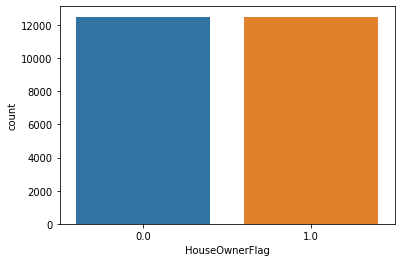

In [ ]:
#To correct oversampling
import seaborn as sns
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE

oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

ax = sns.countplot(x=y,data=TAB23)
print(y.value_counts())

In [ ]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50, random_state=600)

In [ ]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

**Training a Decision Tree Model**


In [ ]:
#Import DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier

#Create an instance of DecisionTreeClassifier() called dtree and fit it to the training data.
dtree = DecisionTreeClassifier()
dtree.fit(X_train,y_train)

DecisionTreeClassifier()

**Predictions and Evaluation of Decision Tree**

In [ ]:
#Create predictions from the test set and create a classification report and a confusion matrix.
from sklearn.metrics import classification_report,confusion_matrix
predictions = dtree.predict(X_test)

print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

         0.0       0.67      0.70      0.68      6290
         1.0       0.68      0.65      0.66      6212

    accuracy                           0.67     12502
   macro avg       0.67      0.67      0.67     12502
weighted avg       0.67      0.67      0.67     12502



In [ ]:
#Print the confusion Matrix
print(confusion_matrix(y_test,predictions))

[[4372 1918]
 [2190 4022]]


**Training the Random Forest model**

In [ ]:
# Create an instance of the RandomForestClassifier class and fit it to training data
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 600)
classifier.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', random_state=600)

In [ ]:
# Predicting the Test set results
y_pred = classifier.predict(X_test)


In [ ]:
# Making the Confusion Matrix
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.67      0.70      0.68      6290
         1.0       0.68      0.65      0.66      6212

    accuracy                           0.67     12502
   macro avg       0.67      0.67      0.67     12502
weighted avg       0.67      0.67      0.67     12502



[[4372 1918]
 [2190 4022]]


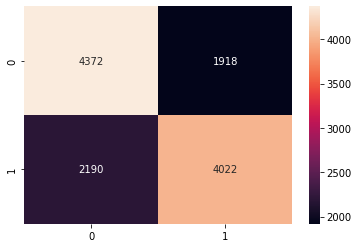

In [ ]:
#Confusion Matrix
cm = (confusion_matrix(y_test,y_pred))
sns.heatmap(cm,annot=True,fmt="d")
print(cm)
plt.show()

In [ ]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
#plt.plot([0, 1], [0, 1])
#plt.plot(fpr, tpr)
#plt.xlabel('False Positive Rate')
#plt.ylabel('True Positive Rate')
#plt.title('ROC')
#plt.show()



###**Price Prediction**

Merging FactInternet Sales,Product, Geography, and SalesTerritory Tables

In [ ]:
#Joining the tables and selecting columns
from pyspark.sql.functions import col
DimGeography1 = DimGeography.join(DimSalesTerritory, how="inner",on=["SalesTerritoryKey"])
DimGeography2 = DimGeography1.select(col("SalesTerritoryKey"),col("City"),col("EnglishCountryRegionName"),col("SalesTerritoryGroup"),col('SalesTerritoryCountry'))
DimGeography2.show(2)
FactSales1 = FactSales.join(DimGeography2, how="inner", on=["SalesTerritoryKey"])
FactSales2 = FactSales1.join(DimProduct, how="inner", on=["ProductKey"])
FactSales3 = FactSales2.join(DimCustomer, how="inner",on=["CustomerKey"])
FactSales4 = FactSales3.join(DimCurrency, how="inner", on=["CurrencyKey"])
#FactSales4.show(2)

#Selecting required columns
FactSalesCols = FactSales4.select(col("EnglishProductName"),col("TotalProductCost"),col("EnglishCountryRegionName"),col("OrderQuantity"),col("ProductStandardCost"),col("UnitPrice"),col("SalesAmount"),col("Freight"),col("TaxAmt"))
FactSalesCols.show(2)

+-----------------+------------+------------------------+-------------------+---------------------+
|SalesTerritoryKey|        City|EnglishCountryRegionName|SalesTerritoryGroup|SalesTerritoryCountry|
+-----------------+------------+------------------------+-------------------+---------------------+
|                1|Rock Springs|           United States|      North America|        United States|
|                1|    Cheyenne|           United States|      North America|        United States|
+-----------------+------------+------------------------+-------------------+---------------------+
only showing top 2 rows

+-------------------+----------------+------------------------+-------------+-------------------+---------+-----------+-------+------+
| EnglishProductName|TotalProductCost|EnglishCountryRegionName|OrderQuantity|ProductStandardCost|UnitPrice|SalesAmount|Freight|TaxAmt|
+-------------------+----------------+------------------------+-------------+-------------------+--------

In [ ]:
#Select required columns, group by Cities, and aggregate sum of Sales, count of Orders etc
from pyspark.sql.functions import desc
from pyspark.sql.functions import *
#Orders by Cities
OrderByCity= FactSales4.select(['EnglishProductName', 'TotalProductCost','City','SalesTerritoryCountry', 'OrderQuantity', 'ProductStandardCost', 'SalesAmount', 'TaxAmt']) \
.groupBy("City").agg(count(col("OrderQuantity"))) \
.orderBy(desc(count(col("OrderQuantity"))))

#SalesAmount by Cities
SalesByCity= FactSales4.select(['EnglishProductName', 'TotalProductCost','City','SalesTerritoryCountry', 'OrderQuantity', 'ProductStandardCost', 'SalesAmount', 'TaxAmt']) \
.groupBy("City").agg(sum(col("SalesAmount"))) \
.orderBy(desc(sum(col("SalesAmount"))))

#Create measured column for Profit
Factsales4 = FactSales4.withColumn('Profit', FactSales4['SalesAmount'] -FactSales4['TotalProductCost'])

#Profit by Cities
ProfitByCity= Factsales4.select(['EnglishProductName', 'TotalProductCost','EnglishCountryRegionName','City', 'OrderQuantity', 'ProductStandardCost', 'SalesAmount', 'TaxAmt','Profit']) \
.groupBy("City").agg(sum(col("Profit"))) \
.orderBy(desc(sum(col("Profit"))))

#Average Tax paid by Cities
TaxByCity= FactSales4.select(['EnglishProductName', 'TotalProductCost','EnglishCountryRegionName','City', 'OrderQuantity', 'ProductStandardCost', 'SalesAmount', 'TaxAmt']) \
.groupBy("City").agg(avg(col("TaxAmt"))) \
.orderBy(desc(avg(col("TaxAmt"))))


#DealerPrice by Cities
DealerPricebyCities = FactSales4.select(['EnglishProductName', 'TotalProductCost','EnglishCountryRegionName','City', 'OrderQuantity', 'ProductStandardCost', 'SalesAmount', 'TaxAmt','DealerPrice']) \
.groupBy("City").agg(sum(col("DealerPrice"))) \
.orderBy(desc(sum(col("DealerPrice"))))

#Freight by Cities
FreightByCities= FactSales4.select(['EnglishProductName', 'TotalProductCost','EnglishCountryRegionName','City', 'OrderQuantity', 'ProductStandardCost', 'SalesAmount','Freight']) \
.groupBy("City").agg(sum(col("Freight"))) \
.orderBy(desc(sum(col("Freight"))))

DataByCity = OrderByCity.join (SalesByCity, how="inner", on="City")
DataByCity2 = DataByCity.join(ProfitByCity, how="inner", on=["City"])
DataByCity3 = DataByCity2.join(TaxByCity, how="inner", on=["City"])
DataByCity4 = DataByCity3.join(DealerPricebyCities, how="inner", on=["City"])
DataByCity5 = DataByCity4.join(FreightByCities,how="inner", on=["City"])

#Renaming the Columns
Tab_a =DataByCity5.withColumnRenamed("count(OrderQuantity)","Quantity")
Tab_b =Tab_a.withColumnRenamed("sum(SalesAmount)","SalesAmount")
Tab_c =Tab_b.withColumnRenamed("sum(Profit)","Profit")
Tab_d =Tab_c.withColumnRenamed("avg(TaxAmt)","Avg Tax")
Tab_e =Tab_d.withColumnRenamed("sum(DealerPrice)","DealerPrice")
Tab_f =Tab_e.withColumnRenamed("sum(Freight)","Freight")

Tab_f.printSchema()
Tab_f.show(2)


root
 |-- City: string (nullable = true)
 |-- Quantity: long (nullable = false)
 |-- SalesAmount: double (nullable = true)
 |-- Profit: double (nullable = true)
 |-- Avg Tax: double (nullable = true)
 |-- DealerPrice: double (nullable = true)
 |-- Freight: double (nullable = true)

+----------+--------+------------------+-----------------+------------------+------------------+------------------+
|      City|Quantity|       SalesAmount|           Profit|           Avg Tax|       DealerPrice|           Freight|
+----------+--------+------------------+-----------------+------------------+------------------+------------------+
|  Bluffton|      39|12238.849599999998|5332.426200000002| 25.10533333333333| 7343.309799999999| 305.9726999999999|
|Pnot-Rouge|    7620|1977844.8620999514|829921.5011999991|20.764775787401316|1186706.9171999483|49446.448100001995|
+----------+--------+------------------+-----------------+------------------+------------------+------------------+
only showing top 2 ro

In [ ]:
#Converting to Pandas Dataframe
FactByCity =Tab_f.toPandas()
FactByCity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 562 entries, 0 to 561
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   City         562 non-null    object 
 1   Quantity     562 non-null    int64  
 2   SalesAmount  562 non-null    float64
 3   Profit       562 non-null    float64
 4   Avg Tax      562 non-null    float64
 5   DealerPrice  562 non-null    float64
 6   Freight      562 non-null    float64
dtypes: float64(5), int64(1), object(1)
memory usage: 30.9+ KB


In [ ]:
FactByCity.describe()

,Quantity,SalesAmount,Profit,Avg Tax,DealerPrice,Freight
count,562.000000,5.620000e+02,5.620000e+02,562.000000,5.620000e+02,5.620000e+02
mean,7824.651246,3.615730e+06,1.492768e+06,31.764403,2.169438e+06,9.039359e+04
std,8026.424767,3.927866e+06,1.612253e+06,10.817069,2.356720e+06,9.819700e+04
min,20.000000,3.000830e+03,1.350920e+03,12.003320,1.800498e+03,7.502160e+01
25%,39.000000,1.223885e+04,5.332426e+03,20.764776,7.343310e+03,3.059727e+02
50%,7620.000000,3.391712e+06,1.390491e+06,32.468512,2.035027e+06,8.479312e+04
75%,12265.000000,5.718151e+06,2.371763e+06,38.057111,3.430890e+06,1.429543e+05
max,96684.000000,4.748397e+07,1.946687e+07,54.318476,2.849038e+07,1.187104e+06


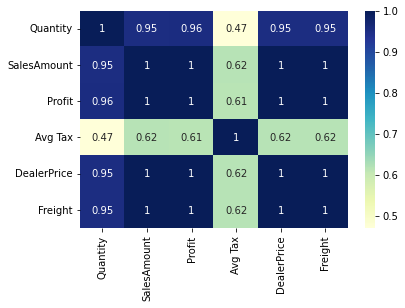

In [ ]:
#Checking for Correlation
sns.heatmap(FactByCity.corr(), cmap="YlGnBu", annot=True)

In [ ]:
# Splitting the dataset features into X and y
X = FactByCity[['Quantity','SalesAmount','Avg Tax','Freight','DealerPrice']]
y = FactByCity['Profit']

In [ ]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=101)

In [ ]:
#Creating the model
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X_train,y_train)

LinearRegression()

In [ ]:
#Model evaluation
# print the intercept
print(lm.intercept_)

-830.4617202582303


In [ ]:
coeff_df = pd.DataFrame(lm.coef_,X.columns,columns=['Coefficient'])
coeff_df

,Coefficient
Quantity,5.904842e+01
SalesAmount,1.093149e+07
Avg Tax,7.610697e+01
Freight,-1.337744e+06
DealerPrice,-1.816340e+07


In [ ]:
#Interpreting the coefficients:

#Holding all other features fixed, a 1 unit increase in Quantity is associated with an increase of $5.9 in Profit
#Holding all other features fixed, a $1  increase in Avg Tax is associated with an *increase of $7.6 in Profit
#Holding all other features fixed, a $1 increase in SalesAmount is associated with an *increase of $1.0
#Holding all other features fixed, a $1 increase in Freight is associated with an decrease of $1.37 Profit
#Holding all other features fixed, a $1 increase in DealerPrice is associated with n decrease of $1.8 Profit

Text(0.5, 1.0, 'Real Test versus Predicted Values')

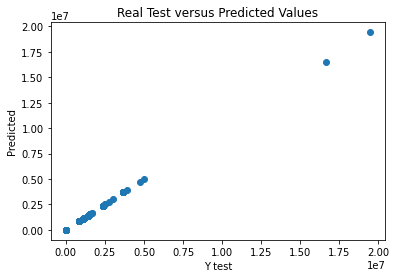

In [ ]:
#Scatterplot of the real test values against predicted values
import matplotlib as plt
%matplotlib inline
predictions = lm.predict(X_test)
plt.pyplot.scatter(y_test, predictions)
plt.pyplot.ylabel('Predicted')
plt.pyplot.xlabel('Y test')
plt.pyplot.title('Real Test versus Predicted Values')

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



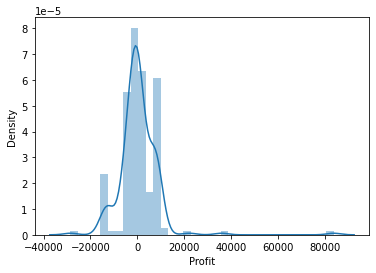

In [ ]:
#Plotting histogram for the residuals
sns.distplot((y_test-predictions),bins=35)


Residual plot looks fairly normally distributed, so the assumption on the linear modeling seems to be fulfilled.

In [ ]:
#Regression Evaluation Metrics
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 4819.0968508186215
MSE: 74243376.17532904
RMSE: 8616.459607943918


In [ ]:
#Prediction score
from sklearn.metrics import r2_score
r2_score(y_test, predictions)

0.9999807889901394

The model has a r2 score of 0.99, this indicates that Profit can be perfectly explained without error by the selected feature variables.